<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product
#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio






In [2]:
[board,profile_path,number_of_chips]=obtain_board()

In [3]:

#Initialization
model = board.get_model()
model.reset(ResetType.PowerCycle, (1 << number_of_chips) - 1)
time.sleep(1)
myConfig = model.get_configuration()
model.apply_configuration(myConfig)
time.sleep(1)

#Set up network
network = Network(config=myConfig, profile_path=profile_path, num_chips=number_of_chips)

input = network.add_virtual_group(size=1)#normal input
test_neurons = network.add_group(chip=0, core=1, size=64)

inp=.5
recc=1-inp
recc_exc=recc*.08
recc_inh=recc*.02

#Input Connections
network.add_connection(source=input, target=test_neurons, probability=inp,
                  dendrite=Dendrite.ampa, weight=[True, False, False, False],repeat=1)
network.add_connection(source=test_neurons, target=test_neurons, probability=recc_exc,
                  dendrite=Dendrite.ampa, weight=[False, True, False, False],repeat=1)
network.add_connection(source=test_neurons, target=test_neurons, probability=recc_inh,
                  dendrite=Dendrite.gaba, weight=[False, False, True, False],repeat=1)
network.connect()

neuron_measure=0
#set neuron to monitor
myConfig.chips[0].cores[c].neuron_monitoring_on = True
myConfig.chips[0].cores[c].monitored_neuron =  neuron_measure
model.apply_configuration(myConfig)
time.sleep(0.1)



In [16]:
input_events=regular_gen(input,1,100,1)

c=0
#Set neurons spiking threadholds to maximum and leakage to maximum
set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_GAIN_N',4,200)
set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_REFR_N',3,200)
set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_SPKTHR_P',3,100)
set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_LEAK_N',1,100)
set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W0_P', 3,200)#Input Channel Weight
set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W1_P', 2,200)#Recurrent Excitatory Weight
set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W2_P', 2,100)#Inhibitory Weight
set_parameter(myConfig.chips[0].cores[c].parameters, 'SYPD_EXT_N', 3, 200)


set_parameter(myConfig.chips[0].cores[c].parameters, 'DEGA_ITAU_P',leak_coarse,leak_fine)# SST to PC
set_parameter(myConfig.chips[0].cores[c].parameters, 'DEGA_IGAIN_P',5,100)

set_parameter(myConfig.chips[0].cores[c].parameters,'DEAM_ETAU_P',2,10)
set_parameter(myConfig.chips[0].cores[c].parameters,'DEAM_EGAIN_P',3,180) 
model.apply_configuration(myConfig)
time.sleep(0.1)




In [17]:
print('initilize run dynapse')
ts = get_fpga_time(board=board) + 100000
min_delay = 0
print("\nsetting virtual neurons\n")
send_virtual_events(board=board, virtual_events=input_events, offset=int(ts), min_delay=int(min_delay))
output_events = [[], []]
get_events(board=board, extra_time=10000, output_events=output_events)

initilize run dynapse

setting virtual neurons



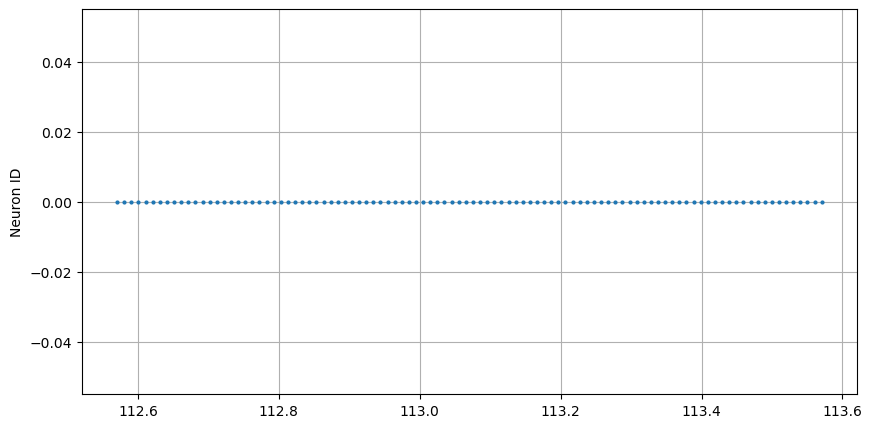

In [18]:
plot_raster(output_events)
